# Load Data

In [1]:
import os
import sys

feat_dir = os.path.join('..', 'ML_Forex_Forecasting')
sys.path.append(feat_dir)

In [2]:
import pandas as pd
from generate_features import generate_features

In [3]:
usd_eur = pd.read_csv(os.path.join(feat_dir, "./USDEUR=X.csv"), parse_dates=['Date'])
eur_chf = pd.read_csv(os.path.join(feat_dir, "./EURCHF=X.csv"), parse_dates=['Date'])
eur_gbp = pd.read_csv(os.path.join(feat_dir, "./EURGBP=X.csv"), parse_dates=['Date'])
gbp_chf = pd.read_csv(os.path.join(feat_dir, "./GBPCHF=X.csv"), parse_dates=['Date'])
usd_chf = pd.read_csv(os.path.join(feat_dir, "./USDCHF=X.csv"), parse_dates=['Date'])
usd_gbp = pd.read_csv(os.path.join(feat_dir, "./USDGBP=X.csv"), parse_dates=['Date'])

In [4]:
data = usd_gbp

In [5]:
feats = generate_features(data)
print(f"EUR/CHF Features shape: {feats.shape}")
display(feats.head())

/usr/local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


EUR/CHF Features shape: (261, 28)


,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-03,0.823231,1.000000,0.999889,-0.000276,0.821073,-0.166832,0.808415,1.355945,-0.166235,...,-13.417576,-46.868713,-6.257833,-4048.504950,51.687019,-2.674181,0.005986,0.005147,51.687019,0.82022
1,2023-11-02,0.823912,1.000000,0.999851,0.001898,0.820840,-0.235751,0.971239,0.675654,-0.236676,...,-29.529883,-52.433173,-38.479160,-5606.709379,52.602051,-0.170413,0.006857,0.006257,52.602051,0.82087
2,2023-11-01,0.824287,1.000000,1.000006,-0.001609,0.820350,-0.420754,0.734517,0.905955,-0.421449,...,15.450779,10.620508,-42.204763,-5592.890455,55.448772,7.610794,0.007728,0.007481,55.448772,0.82290
3,2023-10-31,0.822878,1.012431,1.000526,-0.003502,0.819682,-0.204354,0.902361,3.675128,-0.203644,...,-37.219043,1993.725383,-45.988930,-4702.776488,54.410492,4.577080,0.007893,0.007798,54.410492,0.82198
4,2023-10-30,0.822007,1.000000,0.999801,0.001999,0.819226,0.288756,1.077513,-5.749885,-0.289510,...,20.140879,56.137304,130.517454,-4590.726501,59.337534,17.951895,0.008548,0.008914,59.337534,0.82551


In [6]:
feats.columns

Index(['Date', 'opt_sine_offset', 'opt_sine_amp', 'opt_sine_freq',
       'opt_sine_phase', 'opt_fourier_offset', 'opt_fourier_cosamp',
       'opt_fourier_cosfreq', 'opt_fourier_cosphase', 'opt_fourier_sinamp',
       'opt_fourier_sinfreq', 'opt_fourier_sinphase', 't', 'Slopes',
       'autocorrelation', 'pca', 'ica', 'mean_abs', 'ROC1', 'ROC5', 'ROC20',
       'WILLIAMS14', 'RSI14', 'CMO9', 'DEMA9', 'TEMA9', 'STOCH14', 'Close'],
      dtype='object')

# 1. Prepare X_train, Y_train, X_test, Y_test

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# use the past 20 days to train the model
def prepare_train_test(df: pd.DataFrame, n_lag_features: int = 10, test_size: float = 0.2, n_days_ahead: int = 5):
    df = df.copy()
    df.drop(['t'], axis=1)
    XY = []
    
    for col in df.columns:
        if col == 'Close':
            closes = pd.DataFrame()
            for i in range(1, n_days_ahead + 1):
                lag_feature_name = f'{col}_Day_{i}'
                closes[lag_feature_name] = df[col].shift(i)
            XY.append(closes)
        elif col != 'Date':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            XY.append(col_lag_features)
    df = pd.concat(XY, axis=1)
    df.dropna(inplace=True)
    
    Y_columns = [f'{col}_Day_{i}' for i in range(1, n_days_ahead + 1)]
    Y = df[Y_columns]
    X = df.drop(columns=Y_columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [9]:
n_days_ahead = 5 # predict the next 5 days
n_lag_features = 10 # how many past days used for predictions

In [10]:
X_train, X_test, Y_train, Y_test = prepare_train_test(feats, n_lag_features=n_lag_features, n_days_ahead=n_days_ahead)

In [11]:
X_train.head()

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
159,0.816019,0.818733,0.821251,0.822797,0.823932,0.825286,0.827507,0.830859,0.835569,0.838260,...,42.599578,40.142115,40.223320,42.653703,39.472295,43.349127,47.147889,49.311467,44.580053,43.452320
216,0.829918,0.829083,0.829212,0.829734,0.830067,0.829295,0.827378,0.826076,0.824923,0.822556,...,49.859592,55.315980,49.886883,46.187707,50.007936,51.750215,51.820067,48.676005,49.958923,51.000701
123,0.795887,0.793419,0.792542,0.793461,0.795010,0.797090,0.797883,0.798902,0.800208,0.800632,...,46.717828,52.373561,47.853938,36.352604,36.497613,37.205544,35.469899,38.060291,38.867892,44.549282
200,0.807663,0.808163,0.808757,0.811071,0.813720,0.815892,0.818458,0.820132,0.820467,0.821864,...,36.462680,36.592900,40.668897,36.684217,34.550937,35.090338,36.969243,39.719467,43.427810,42.187005
245,0.839988,0.842373,0.841867,0.843127,0.844602,0.846504,0.854624,0.860376,0.866004,0.870592,...,32.627623,33.573894,38.278904,40.281379,37.620441,38.326062,35.988449,36.805539,39.942114,38.145656


In [12]:
Y_train.head() # closing prices for the next 1-5 days

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
159,0.813170,0.811000,0.81211,0.807280,0.81387
216,0.839470,0.825330,0.82069,0.822740,0.82240
123,0.801000,0.801102,0.80565,0.802500,0.80422
200,0.806432,0.809480,0.81242,0.807100,0.81813
245,0.829550,0.836100,0.83704,0.827986,0.81571


## Scale features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


## Reduce feature size

In [14]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca.transform(X_test_scaled)


## Scale Ys

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# 2. Train SVR

In [16]:
from sklearn.svm import SVR

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


In [17]:

Y_train_scaled.shape

(197, 5)

In [18]:
# svrs: [svr_d1, svr_d2, svr_d3, svr_d4, svr_d5], a model for each day
svrs = []
for i in range(0, n_days_ahead):
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train_scaled_reduced, Y_train_scaled[:, i])
    svrs.append(svr)

In [19]:
pred_train = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_train[f'Close_Day_{i}'] = svrs[i-1].predict(X_train_scaled_reduced)
pred_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.184975,0.078234,-0.078441,-0.105332,-0.105411
1,1.062499,0.933418,0.916331,0.961122,0.986511
2,-0.410249,-0.424193,-0.453644,-0.575305,-0.680794
3,0.088139,0.170817,0.357320,0.465588,0.605632
4,1.148536,1.526685,1.562706,1.090598,0.415314
...,...,...,...,...,...
192,0.009304,-0.015676,-0.023194,-0.128414,-0.199469
193,0.720918,0.812505,0.872241,0.891033,0.814941
194,-1.395844,-1.318983,-1.258673,-1.205038,-1.106680
195,1.399421,1.242135,1.197445,1.318367,1.547244


In [20]:
mse = mean_squared_error(Y_train_scaled, pred_train)
mse

0.05715017831330656

In [21]:
# transform back to the original scale
Y_train_pred = scaler_y.inverse_transform(pred_train)
mse = mean_squared_error(Y_train, Y_train_pred)
mse

1.8700722015068813e-05

In [22]:
Y_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
159,0.813170,0.811000,0.81211,0.807280,0.81387
216,0.839470,0.825330,0.82069,0.822740,0.82240
123,0.801000,0.801102,0.80565,0.802500,0.80422
200,0.806432,0.809480,0.81242,0.807100,0.81813
245,0.829550,0.836100,0.83704,0.827986,0.81571
...,...,...,...,...,...
111,0.798340,0.804490,0.80430,0.804600,0.80348
19,0.816300,0.813580,0.81193,0.820800,0.82279
97,0.782960,0.784490,0.78557,0.786660,0.78464
184,0.830620,0.825810,0.82988,0.832100,0.83665


In [23]:
pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
159,0.810066,0.808003,0.805111,0.804657,0.804508
216,0.826135,0.823519,0.823020,0.823859,0.824207
123,0.799166,0.798888,0.798357,0.796195,0.794128
200,0.808293,0.809683,0.812956,0.814937,0.817336
245,0.827711,0.834283,0.834657,0.826190,0.813902
...,...,...,...,...,...
111,0.806849,0.806299,0.806106,0.804241,0.802811
19,0.819880,0.821325,0.822226,0.822597,0.821112
97,0.781117,0.782654,0.783864,0.784856,0.786444
184,0.832305,0.829120,0.828081,0.830291,0.834323


In [24]:
pred_test = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_test[f'Close_Day_{i}'] = svrs[i-1].predict(X_test_scaled_reduced)
pred_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.341259,-0.268259,-0.234717,-0.132319,0.038814
1,0.779181,0.826810,0.875838,0.820872,0.792357
2,1.280557,1.316626,1.154856,1.138916,1.268796
3,-1.233371,-1.219523,-1.308153,-1.352508,-1.374133
4,0.239463,0.119113,0.018922,-0.053132,-0.105904
5,1.314228,1.204142,1.188918,1.259179,1.387452
6,0.057397,0.169802,0.477694,0.581318,0.629318
7,-0.153923,-0.318735,-0.400247,-0.442103,-0.484145
8,0.799789,0.875682,0.840124,0.795194,0.920800
9,0.667476,0.462075,0.586154,0.587519,0.628502


In [25]:
mse = mean_squared_error(Y_test_scaled, pred_test)
mse

0.15421364996775982

In [26]:
# transform back to the original scale
Y_test_pred = scaler_y.inverse_transform(pred_test)
mse = mean_squared_error(Y_test, Y_test_pred)
mse

5.057659264050405e-05

In [27]:
Y_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.800530,0.800670,0.806330,0.806610,0.807510
11,0.823910,0.822100,0.816310,0.822240,0.826210
186,0.835050,0.831270,0.830620,0.825810,0.829880
91,0.792730,0.787820,0.787840,0.786310,0.787120
160,0.816593,0.813170,0.811000,0.812110,0.807280
183,0.825810,0.829880,0.832100,0.836650,0.829080
199,0.809480,0.812420,0.807100,0.818130,0.830210
109,0.804300,0.804600,0.803480,0.796210,0.794850
14,0.818900,0.821100,0.823490,0.823910,0.822100
239,0.820180,0.824198,0.818840,0.817260,0.817050


In [28]:
pd.DataFrame(Y_test_pred, columns=Y_test.columns, index=Y_test.index)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.800429,0.801717,0.802298,0.804171,0.807110
11,0.820947,0.821585,0.822291,0.821334,0.820705
186,0.830129,0.830471,0.827314,0.827060,0.829300
91,0.784093,0.784458,0.782973,0.782201,0.781619
160,0.811064,0.808745,0.806864,0.805597,0.804499
183,0.830745,0.828431,0.827927,0.829226,0.831441
199,0.807730,0.809665,0.815123,0.817020,0.817763
109,0.803860,0.800801,0.799318,0.798593,0.797675
14,0.821325,0.822471,0.821648,0.820871,0.823022
239,0.818902,0.814967,0.817076,0.817132,0.817749


In [29]:
Y_test_pred

array([[0.80042934, 0.80171686, 0.80229799, 0.80417104, 0.80711005],
       [0.82094718, 0.8215847 , 0.82229102, 0.82133366, 0.82070461],
       [0.83012854, 0.83047142, 0.82731412, 0.82706019, 0.82929997],
       [0.78409271, 0.7844581 , 0.78297319, 0.78220097, 0.7816193 ],
       [0.8110637 , 0.80874496, 0.80686419, 0.80559682, 0.80449922],
       [0.83074513, 0.82843063, 0.82792734, 0.82922557, 0.83144063],
       [0.80772964, 0.80966461, 0.81512335, 0.81702038, 0.81776326],
       [0.80385989, 0.80080108, 0.79931799, 0.79859323, 0.79767543],
       [0.82132457, 0.82247138, 0.82164808, 0.82087132, 0.82302184],
       [0.8189016 , 0.81496731, 0.81707591, 0.81713204, 0.81774852],
       [0.81683011, 0.81619075, 0.81790974, 0.81746946, 0.81913832],
       [0.82704128, 0.82763499, 0.82369198, 0.82267278, 0.82496856],
       [0.82202612, 0.81854026, 0.81532308, 0.81632028, 0.81905819],
       [0.83120036, 0.8313801 , 0.82921216, 0.8290055 , 0.82906678],
       [0.78170628, 0.7834564 , 0.

In [30]:
df_test_pred_d1 = pd.DataFrame(Y_test_pred[:,0], Y_test.index)

In [31]:
df_test_pred_d1 = df_test_pred_d1.sort_index()

In [32]:
df_test = Y_test.sort_index()

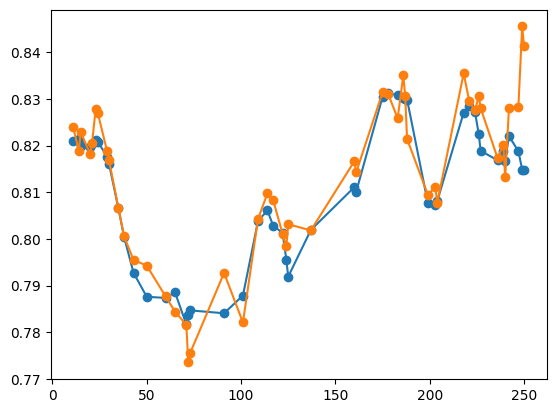

In [33]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_1'], marker='o')

In [34]:
df_test_pred_d2 = pd.DataFrame(Y_test_pred[:,1], Y_test.index)

In [35]:
df_test_pred_d2 = df_test_pred_d2.sort_index()

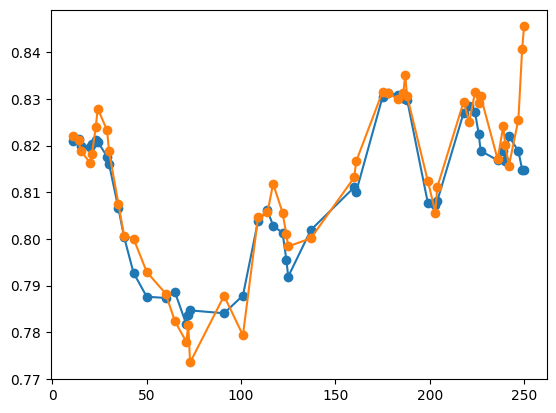

In [36]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_2'], marker='o')

# Predict next 5 days

In [37]:
feats

,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-03,0.823231,1.000000,0.999889,-0.000276,0.821073,-0.166832,0.808415,1.355945,-0.166235,...,-13.417576,-46.868713,-6.257833,-4048.504950,51.687019,-2.674181,0.005986,0.005147,51.687019,0.82022
1,2023-11-02,0.823912,1.000000,0.999851,0.001898,0.820840,-0.235751,0.971239,0.675654,-0.236676,...,-29.529883,-52.433173,-38.479160,-5606.709379,52.602051,-0.170413,0.006857,0.006257,52.602051,0.82087
2,2023-11-01,0.824287,1.000000,1.000006,-0.001609,0.820350,-0.420754,0.734517,0.905955,-0.421449,...,15.450779,10.620508,-42.204763,-5592.890455,55.448772,7.610794,0.007728,0.007481,55.448772,0.82290
3,2023-10-31,0.822878,1.012431,1.000526,-0.003502,0.819682,-0.204354,0.902361,3.675128,-0.203644,...,-37.219043,1993.725383,-45.988930,-4702.776488,54.410492,4.577080,0.007893,0.007798,54.410492,0.82198
4,2023-10-30,0.822007,1.000000,0.999801,0.001999,0.819226,0.288756,1.077513,-5.749885,-0.289510,...,20.140879,56.137304,130.517454,-4590.726501,59.337534,17.951895,0.008548,0.008914,59.337534,0.82551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2022-11-10,0.878591,1.000000,1.000043,-0.003364,0.882687,0.558161,0.978266,1.190969,0.558172,...,28.341245,2.004028,-24.637429,-2086.301348,50.917662,3.205365,0.058241,0.059403,50.917662,0.87965
257,2022-11-09,0.879177,1.000000,0.999733,0.000411,0.883055,-0.784316,0.954637,0.997205,-0.783883,...,-5.001495,-8.760565,-48.216737,-1896.283258,43.351927,-16.075630,0.055868,0.055971,43.351927,0.86560
258,2022-11-08,0.880192,1.000000,0.999880,-0.001812,0.883500,-0.673642,0.931588,0.859684,0.672769,...,-21.485189,-6.737630,-39.875848,-1890.489695,44.536107,-13.184401,0.059693,0.061401,44.536107,0.86821
259,2022-11-07,0.875577,2.655471,1.000709,-0.004310,0.883853,-0.277282,1.065215,-2.101207,-0.278188,...,-16.010738,43.414098,-23.686944,-1858.791582,51.712530,4.551587,0.063735,0.067758,51.712530,0.88249


In [38]:
def prepare_for_pred(df: pd.DataFrame, n_lag_features: int = 10):
    df = df.copy()
    df.drop(['t'], axis=1)
    X = []
    
    for col in df.columns:
        if col == 'Date':
            X.append(df[col])
        elif col != 'Close':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            X.append(col_lag_features)
        
    df = pd.concat(X, axis=1)
    df.dropna(inplace=True)
    return df


In [39]:
input_feats = prepare_for_pred(feats, n_lag_features).iloc[[0]]
input_feats

,Date,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,2023-11-03,0.823231,0.823912,0.824287,0.822878,0.822007,0.822157,0.82136,0.821617,0.822001,...,51.687019,52.602051,55.448772,54.410492,59.337534,57.736859,60.945372,57.108356,50.341368,58.744227


In [40]:
input_feats = input_feats.drop(columns=['Date'])
input_feats

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,0.823231,0.823912,0.824287,0.822878,0.822007,0.822157,0.82136,0.821617,0.822001,0.821898,...,51.687019,52.602051,55.448772,54.410492,59.337534,57.736859,60.945372,57.108356,50.341368,58.744227


In [41]:
input_feats_scaled = scaler.transform(input_feats)

In [42]:
input_feats_scaled_reduced = pca.transform(input_feats_scaled)

In [43]:
preds_scaled = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    preds_scaled[f'Close_Day_{i}'] = svrs[i-1].predict(input_feats_scaled_reduced)
preds_scaled

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.765338,0.767875,0.734214,0.573266,0.394387


In [44]:
preds_unscaled = scaler_y.inverse_transform(preds_scaled)

In [45]:
pd.DataFrame(preds_unscaled, columns=preds_scaled.columns)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.820694,0.820515,0.819741,0.816875,0.813525


In [46]:
outfile = 'predictions_T_svr.csv'

# Save the NumPy matrix to the CSV file (append mode)
with open(outfile, 'a') as f:
    np.savetxt(f, preds_unscaled, delimiter=',')